In [1]:
from integsol.mesh.mesh import Mesh
from integsol.compute.vectors import VectorField
from integsol.compute.operators import (
    IntegralConvolutionOperator as ICO,
    CrossProductOperator as CPO,
)
from integsol.compute.kernels import demagnetization_tensor_kernel as dtk
import numpy as np
from torch.linalg import eig
from torch import (
    Tensor,
    dot,
    matmul,
    mv,
)


In [2]:
M_s = 1.45 * 1e4
gamms = 2.25 * 1e4

In [3]:
mesh = Mesh.read(path="/home/aluatar/integsol/test_inputs/mesh_coerser.mphtxt")

Begin calculation of elements measures.
Calculate measures for vtx type of elements
Calculate measures for edg type of elements
Progress: 3.57%

Progress: 98.21%

Calculate measures for tri type of elements
Progress: 99.75%

Calculate measures for tet type of elements
Progress: 99.95%

Calculation of measures of all elements finished in 10.655482053756714 seconds.


In [4]:
centers = mesh.elements_centers['tet'].T
volumes = mesh.elements_measures['tet']

In [5]:
dtk(centers.T[5], centers.T[90]) * volumes[90]

array([[ 2.45393293e-03, -3.38393799e-03, -4.72031437e-04],
       [-3.38393799e-03, -7.59637953e-05,  3.27482902e-04],
       [-4.72031437e-04,  3.27482902e-04, -2.37796914e-03]])

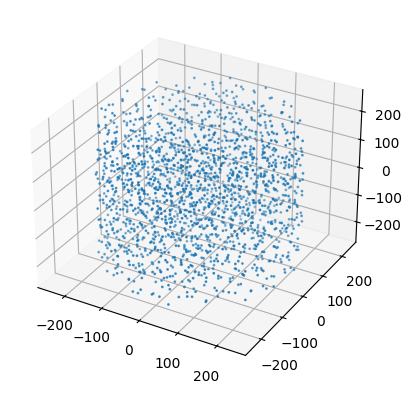

In [6]:
import matplotlib.pyplot as plt 
import numpy as np

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(xs=np.float64(centers[0]), ys=np.float64(centers[1]), zs=np.float64(centers[2]), s=1)

In [ ]:
coord_to_write = []
X, Y, Z =[], [], []
for coordinate in centers.T:
    X.append(coordinate[0])
    Y.append(coordinate[1])
    Z.append(coordinate[2])

coord_to_write = zip(X,Y,Z)

from datetime import datetime
import csv

with open(F"/home/aluatar/integsol/outputs/interpolation_coordinates/coordinates_{datetime.now()}.txt", 'w') as _csv:
    writer = csv.writer(_csv, delimiter='\t')
    writer.writerows(coord_to_write)

In [7]:
M0 = VectorField.read_to_mesh(
    path="/home/aluatar/integsol/test_inputs/magnetization_coerser.txt",
    mesh=mesh,
    dim=3)


_M0 = np.round(M0.vectorize(),4)

In [8]:
M0_cpo = CPO(
    mesh=mesh,
    left_vector= _M0
)

M0_times_ = M0_cpo.to_mesh_matrix()
M0_times_

tensor([[ 0.0000e+00, -1.0000e+00,  1.0000e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  0.0000e+00, -1.0000e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.0000e-04,  1.0000e-04,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
         -1.0000e+00, -0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
         -0.0000e+00,  1.0000e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -1.0000e-04,  0.0000e+00]])

In [9]:
ico = ICO(kernel=dtk)
int_G_ = ico.to_mesh_matrix(mesh=mesh)

Begin placement of operator on mesh elements' centers.
Progress: 99.95%

Mesh matric of the operator generated in 184.25955080986023 seconds.


In [15]:
int_G_

tensor([[-8.7305e+00,  1.4493e+01,  1.6505e+01,  ..., -6.9684e-05,
          8.7539e-05,  8.8066e-05],
        [ 1.4493e+01,  1.3387e+00,  2.3207e+01,  ...,  8.7539e-05,
          3.3914e-05,  1.5444e-04],
        [ 1.6505e+01,  2.3207e+01,  7.3918e+00,  ...,  8.8066e-05,
          1.5444e-04,  3.5770e-05],
        ...,
        [-1.8333e-04,  2.3031e-04,  2.3170e-04,  ..., -5.5485e+00,
          5.3510e+00,  4.7649e+00],
        [ 2.3031e-04,  8.9225e-05,  4.0632e-04,  ...,  5.3510e+00,
          4.0122e+00,  1.0646e+01],
        [ 2.3170e-04,  4.0632e-04,  9.4109e-05,  ...,  4.7649e+00,
          1.0646e+01,  1.5363e+00]])

In [17]:
Hd = VectorField(mesh=mesh)

_Hd = mv(int_G_, _M0)
Hd.devectorize(_Hd)
max(_Hd)

tensor(6737.4507)

In [18]:
H0 = VectorField(
    mesh=mesh,
    values=np.array([[0,0,5e5 / M_s] for _ in range(len(mesh.elements_centers['tet']))])
)
_H0 = H0.vectorize()
_H0

tensor([ 0.0000,  0.0000, 34.4828,  ...,  0.0000,  0.0000, 34.4828])

In [19]:
H0_cpo = CPO(mesh=mesh, left_vector=_H0)
H0_times_ = H0_cpo.to_mesh_matrix()
H0_times_

tensor([[  0.0000, -34.4828,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ 34.4828,   0.0000,  -0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ -0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000, -34.4828,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,  34.4828,   0.0000,  -0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,  -0.0000,   0.0000,   0.0000]])

In [14]:
Hd_cpo = CPO(mesh=mesh, left_vector=_Hd)
Hd_times_ = Hd_cpo.to_mesh_matrix()
Hd_times_

tensor([[  0.0000,  -7.6134,  24.2546,  ...,   0.0000,   0.0000,   0.0000],
        [  7.6134,   0.0000, -19.3397,  ...,   0.0000,   0.0000,   0.0000],
        [-24.2546,  19.3397,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,  -1.5457,  11.3360],
        [  0.0000,   0.0000,   0.0000,  ...,   1.5457,   0.0000,  -6.0040],
        [  0.0000,   0.0000,   0.0000,  ..., -11.3360,   6.0040,   0.0000]])

In [15]:
M0_times_Int_G_ = matmul(M0_times_,int_G_)

In [ ]:
LinearOperator = 1j * M_s * gamms * (H0_times_ + Hd_times_ - M0_times_Int_G_)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.linspace(0,1,len(LinearOperator[0])), abs(LinearOperator[-1]), s = 2)

ax.scatter(np.linspace(0,1,len(LinearOperator[0])), abs(LinearOperator[0]), s = 2)
plt.yscale('log')

In [ ]:
eigs = eig(LinearOperator)

In [ ]:
LinearOperator

In [ ]:
eigenvals_idx = np.where(abs((1j * eigs.eigenvalues).imag) <= 1e-5)[0]
eigenvals = np.round([-1j * eigs.eigenvalues[i] for i in eigenvals_idx],5)
eigenvals

In [ ]:
eigenvects = eigs.eigenvectors

In [ ]:
eigenvects

In [ ]:
dm = VectorField(mesh=mesh)
dm.devectorize(eigenvects[510])
dm.values

In [22]:
field_Hd = Hd.values.T - H0.values.T
field_Hd

array([[ 19.33971405,  11.8850565 ,  11.60281754, ...,  13.99972534,
          7.62706661,   6.00396919],
       [ 24.25461388,  11.31874371,  14.8130846 , ...,  26.62662888,
         15.802145  ,  11.33600044],
       [-26.86936102, -23.94974337, -28.81713972, ..., -23.40416441,
        -30.66002045, -32.93709932]])

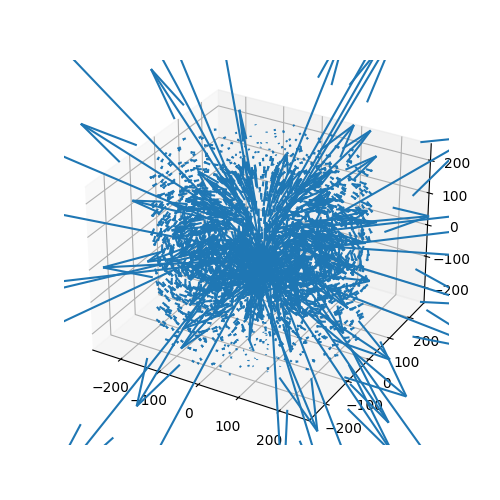

In [23]:
%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    centers[0],
    centers[1],
    centers[2],
    field_Hd[0],
    field_Hd[1],
    field_Hd[2],
    length=0.3,
)

plt.show()

In [ ]:
Hd = mv(mm,_vector_M0[1])
Hd

In [ ]:
H_demg = VectorField(dim=3, coordinates=mesh.coordinates, mesh=mesh)

In [ ]:
np.zeros(shape=(6,3))